# IDS Multiclass Attack Detection

This notebook implements a multiclass Random Forest classifier for the CIC-IDS2017 dataset.
It covers data exploration, preprocessing, model training, and evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Tuple, List, Dict

# Constants
DATASET_PATH = '../dataset/combined_dataset.csv'
OUTPUT_IMGS_PATH = '../assets/imgs/output_charts/'
os.makedirs(OUTPUT_IMGS_PATH, exist_ok=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## 1. Data Loading

In [2]:
def load_data(dataset_path: str) -> pd.DataFrame:
    """
    Load the specified dataset and returns it.
    :param str dataset_path: The path to the dataset to import.
    :return: pd.DataFrame containing the imported dataset.
    """
    print(f"[INFO] Loading dataset from {dataset_path}...")
    df = pd.read_csv(dataset_path, low_memory=False)

    string_cols = ['flow_id', 'timestamp', 'src_ip', 'dst_ip', 'protocol', 'label']
    
    for col in df.columns:
        if col not in string_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')   
    
    print(f"[INFO] Dataset loaded. Shape: {df.shape}")
    return df

## 2. Data Exploration (EDA)

In [3]:
def check_for_nans_and_duplicates(dataframe: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Check for duplicates and NaN values.
    """
    duplicates = dataframe[dataframe.duplicated()]
    print(f"N. of duplicates: {duplicates.shape[0]}")
    
    nan_summary = dataframe.isna().sum()
    nan_columns = nan_summary[nan_summary > 0]
    print(f"\nColumns with NaNs: {len(nan_columns)}")
    if not nan_columns.empty:
        print(nan_columns)
    
    return duplicates, nan_summary

In [4]:
def plot_attacks_distribution(dataframe: pd.DataFrame, target_column: str) -> None:
    """
    Plot the distribution of the attack types.
    """
    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataframe, x=target_column, order=dataframe[target_column].value_counts().index)
    plt.title('Attack Type Distribution', fontsize=15)
    plt.xlabel('Attack Classes', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_IMGS_PATH}attack_distribution.png', dpi=200)
    plt.show()

def plot_class_breakdown_pie(y: np.ndarray, labels: list) -> None:
    """Plot a pie chart of the class distribution."""
    counts = pd.Series(y).value_counts().sort_index()
    class_labels = [labels[i] for i in counts.index]
    
    plt.figure(figsize=(12, 12))
    
    # Only show percentage if > 2% to obtain readable labels
    def make_autopct(pct):
        return ('%1.1f%%' % pct) if pct > 2.0 else ''
    
    plt.pie(counts, labels=None, autopct=make_autopct, startangle=140, pctdistance=0.85)
    plt.legend(class_labels, title="Attack Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title('Attack Class Distribution (Percentage)', fontsize=15)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_IMGS_PATH}class_distribution_pie.png', dpi=200)
    plt.show()

def plot_correlation_heatmap(df: pd.DataFrame, title: str = "Feature Correlation Matrix") -> None:
    """Plot a correlation heatmap for the DataFrame."""
    corr = df.corr()
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title(title, fontsize=15)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_IMGS_PATH}correlation_matrix_{title.replace(" ", "_")}.png', dpi=200)
    plt.show()

## 3. Data Cleaning & Preprocessing

In [5]:
def clean_data(dataset: pd.DataFrame, columns_to_remove: List[str]) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Clean dataset: remove duplicates, handle NaNs, drop irrelevant columns.
    Returns X (features) and y (target).
    """
    print("[INFO] Cleaning data...")
    dataset = dataset.drop_duplicates()
    dataset = dataset.replace([np.inf, -np.inf], np.nan)
    dataset = dataset.dropna()
    
    # Drop irrelevant columns
    existing_cols_to_drop = [c for c in columns_to_remove if c in dataset.columns]
    dataset = dataset.drop(columns=existing_cols_to_drop)

    # Round floats
    float_cols = dataset.select_dtypes(include=['float']).columns
    dataset[float_cols] = dataset[float_cols].round(4)

    # Separate X and y
    y = dataset['label']
    X = dataset.drop(columns=['label'])
    
    print(f"[INFO] Data cleaned. Features: {X.shape[1]}, Samples: {X.shape[0]}")
    return X, y

In [6]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(X: pd.DataFrame) -> Tuple[pd.DataFrame, LabelEncoder]:
    """
    Encode 'protocol' column if present using LabelEncoder.
    Returns encoded DataFrame and the encoder.
    """
    X_encoded = X.copy()
    le = LabelEncoder()
    
    if 'protocol' in X_encoded.columns:
        print("[INFO] Encoding 'protocol' column...")
        # Ensure protocol is string for encoding
        X_encoded['protocol'] = X_encoded['protocol'].astype(str)
        X_encoded['protocol'] = le.fit_transform(X_encoded['protocol'])
        print(f"       Unique protocols encoded: {le.classes_}")
    
    return X_encoded, le

In [7]:
def encode_multiclass_labels(y: pd.Series) -> Tuple[np.ndarray, LabelEncoder]:
    """
    Encode target labels for multiclass classification.
    """
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    print("\n" + "="*60)
    print("MULTICLASS LABEL ENCODING SUMMARY ")
    print("="*60)
    for idx, cls in enumerate(le.classes_):
        count = (y_encoded == idx).sum()
        pct = (count / len(y_encoded)) * 100
        print(f" {idx:>2} | {cls:<25} | {count:>7} samples ({pct:>5.2f}%)")
    print("="*60 + "\n")
    
    return y_encoded, le

In [8]:
from sklearn.model_selection import train_test_split

def split_dataset(X: pd.DataFrame, y: np.ndarray, test_size: float = 0.2, random_state: int = 42):
    """
    Stratified split of the dataset.
    """
    print(f"[INFO] Splitting dataset (test_size={test_size})...")
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

## 4. Feature Engineering & Selection

In [9]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

def remove_low_variance_features(X: pd.DataFrame, threshold: float = 0.01) -> pd.DataFrame:
    """Remove features with variance lower than threshold."""
    print(f"[INFO] Removing low variance features (threshold={threshold})...")
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)
    X_new = X.loc[:, selector.get_support()]
    print(f"       Removed {X.shape[1] - X_new.shape[1]} features. Remaining: {X_new.shape[1]}")
    return X_new

def remove_correlated_features(X: pd.DataFrame, threshold: float = 0.95) -> pd.DataFrame:
    """Remove highly correlated features (Pearson > threshold)."""
    print(f"[INFO] Removing correlated features (threshold={threshold})...")
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    X_new = X.drop(columns=to_drop)
    print(f"       Removed {len(to_drop)} features. Remaining: {X_new.shape[1]}")
    return X_new

def select_top_features_rf(X: pd.DataFrame, y: np.ndarray, k: int = 40, subsample_size: int = 50000) -> Tuple[pd.DataFrame, List[str]]:
    """
    Select top K features using Random Forest Feature Importance.
    Uses a stratified subsample for efficiency.
    """
    k = min(k, X.shape[1])
    print(f"[INFO] Selecting top {k} features using Random Forest Importance...")
    
    # Subsample for speed if dataset is extensive
    if len(X) > subsample_size:
        print(f"       Using subsample of {subsample_size} for feature selection...")
        X_sub, _, y_sub, _ = train_test_split(X, y, train_size=subsample_size, stratify=y, random_state=42)
    else:
        X_sub, y_sub = X, y
        
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_sub, y_sub)
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    top_indices = indices[:k]
    selected_features = X.columns[top_indices].tolist()
    
    print(f"       Selected Features: {selected_features}")
    
    return X[selected_features], selected_features

def scale_data(X_train: pd.DataFrame, X_test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler]:
    """Scale data using StandardScaler."""
    print("[INFO] Scaling features (StandardScaler)...")
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    return X_train_scaled, X_test_scaled, scaler

## 5. Model Training & Evaluation

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

def train_model(X_train: pd.DataFrame, y_train: np.ndarray) -> RandomForestClassifier:
    """
    Train Random Forest Classifier.
    """
    print("[INFO] Training Random Forest Classifier...")
    rf_model = RandomForestClassifier(
        n_estimators=100, 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1,
        random_state=42, 
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    print("[INFO] Training complete.")
    return rf_model

def evaluate_model(model: RandomForestClassifier, X_test: pd.DataFrame, y_test: np.ndarray, label_encoder: LabelEncoder) -> None:
    """
    Evaluate the model on the test set and plot confusion matrix.
    """
    print("[INFO] Evaluating model on test set...")
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n{'='*40}")
    print(f"MODEL EVALUATION")
    print(f"{'='*40}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"{'='*40}\n")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title('Multiclass Confusion Matrix', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_IMGS_PATH}confusion_matrix.png', dpi=200)
    plt.show()

## 6. Hyperparameter Tuning (NEW)

In [11]:
from sklearn.model_selection import RandomizedSearchCV

def optimize_model(X_train: pd.DataFrame, y_train: np.ndarray) -> RandomForestClassifier:
    """
    Perform hyperparameter tuning using RandomizedSearchCV on a subsample of data.
    """
    print(f"\n{'='*40}")
    print(f"HYPERPARAMETER TUNING (RandomizedSearchCV)")
    print(f"{'='*40}")
    
    # 1. Subsample for speed (e.g., 50k samples)
    subsample_size = 50000
    if len(X_train) > subsample_size:
        print(f"[INFO] Subsampling {subsample_size} records for tuning... (Stratified)")
        X_tune, _, y_tune, _ = train_test_split(X_train, y_train, train_size=subsample_size, stratify=y_train, random_state=42)
    else:
        X_tune, y_tune = X_train, y_train
        
    # 2. Define Parameter Grid
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    
    # 3. Randomized Search
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=10,        # Number of parameter settings to sample
        cv=3,             # 3-fold CV for speed
        scoring='f1_weighted',
        verbose=2,
        random_state=42,
        n_jobs=-1
    )
    
    print("[INFO] Starting search...")
    random_search.fit(X_tune, y_tune)
    
    print(f"\nBest Parameters: {random_search.best_params_}")
    print(f"Best CV Score: {random_search.best_score_:.4f}")
    
    # 4. Retrain on FULL train set with best params
    print("\n[INFO] Retraining model on FULL training set with best parameters...")
    best_model = random_search.best_estimator_
    best_model.fit(X_train, y_train)
    
    return best_model

In [12]:
def save_model(model, label_encoder, scaler, selected_features, protocol_encoder, filepath='./models/v2/ids_model.joblib'):
    """
    Save the trained model and associated artifacts in a single package using joblib.
    """
    import joblib
    import os
    
    print(f"[INFO] Saving model package to {filepath}...")
    # Create directory if not exists
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    # Package everything
    model_package = {
        'model': model,
        'label_encoder': label_encoder,
        'scaler': scaler,
        'selected_features': selected_features,
        'protocol_encoder': protocol_encoder
    }
    
    # Save
    joblib.dump(model_package, filepath)
    
    print(f"[SUCCESS] Model saved to: {filepath}")
    print(f"          Contains: model, label_encoder, scaler, selected_features, protocol_encoder")

[INFO] Loading dataset from ../dataset/combined_dataset.csv...
[INFO] Dataset loaded. Shape: (2438053, 122)
N. of duplicates: 2360

Columns with NaNs: 116
src_port                 1
dst_port                 1
duration                 1
packets_count            1
fwd_packets_count        1
                        ..
bwd_packets_IAT_total    1
subflow_fwd_packets      1
subflow_bwd_packets      1
subflow_fwd_bytes        1
subflow_bwd_bytes        1
Length: 116, dtype: int64
[INFO] Cleaning data...
[INFO] Data cleaned. Features: 116, Samples: 2435692
[INFO] Encoding 'protocol' column...
       Unique protocols encoded: ['TCP' 'UDP']

MULTICLASS LABEL ENCODING SUMMARY 
  0 | Benign                    | 1785725 samples (73.31%)
  1 | Botnet_ARES               |    5508 samples ( 0.23%)
  2 | DDoS_LOIT                 |   95733 samples ( 3.93%)
  3 | DoS_GoldenEye             |    8364 samples ( 0.34%)
  4 | DoS_Hulk                  |  347394 samples (14.26%)
  5 | DoS_Slowhttptest        

/Users/marcus/.venvs/mlVenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.7s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.9s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, max_feat

/Users/marcus/.venvs/mlVenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/marcus/.venvs/mlVenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/marcus/.venvs/mlVenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

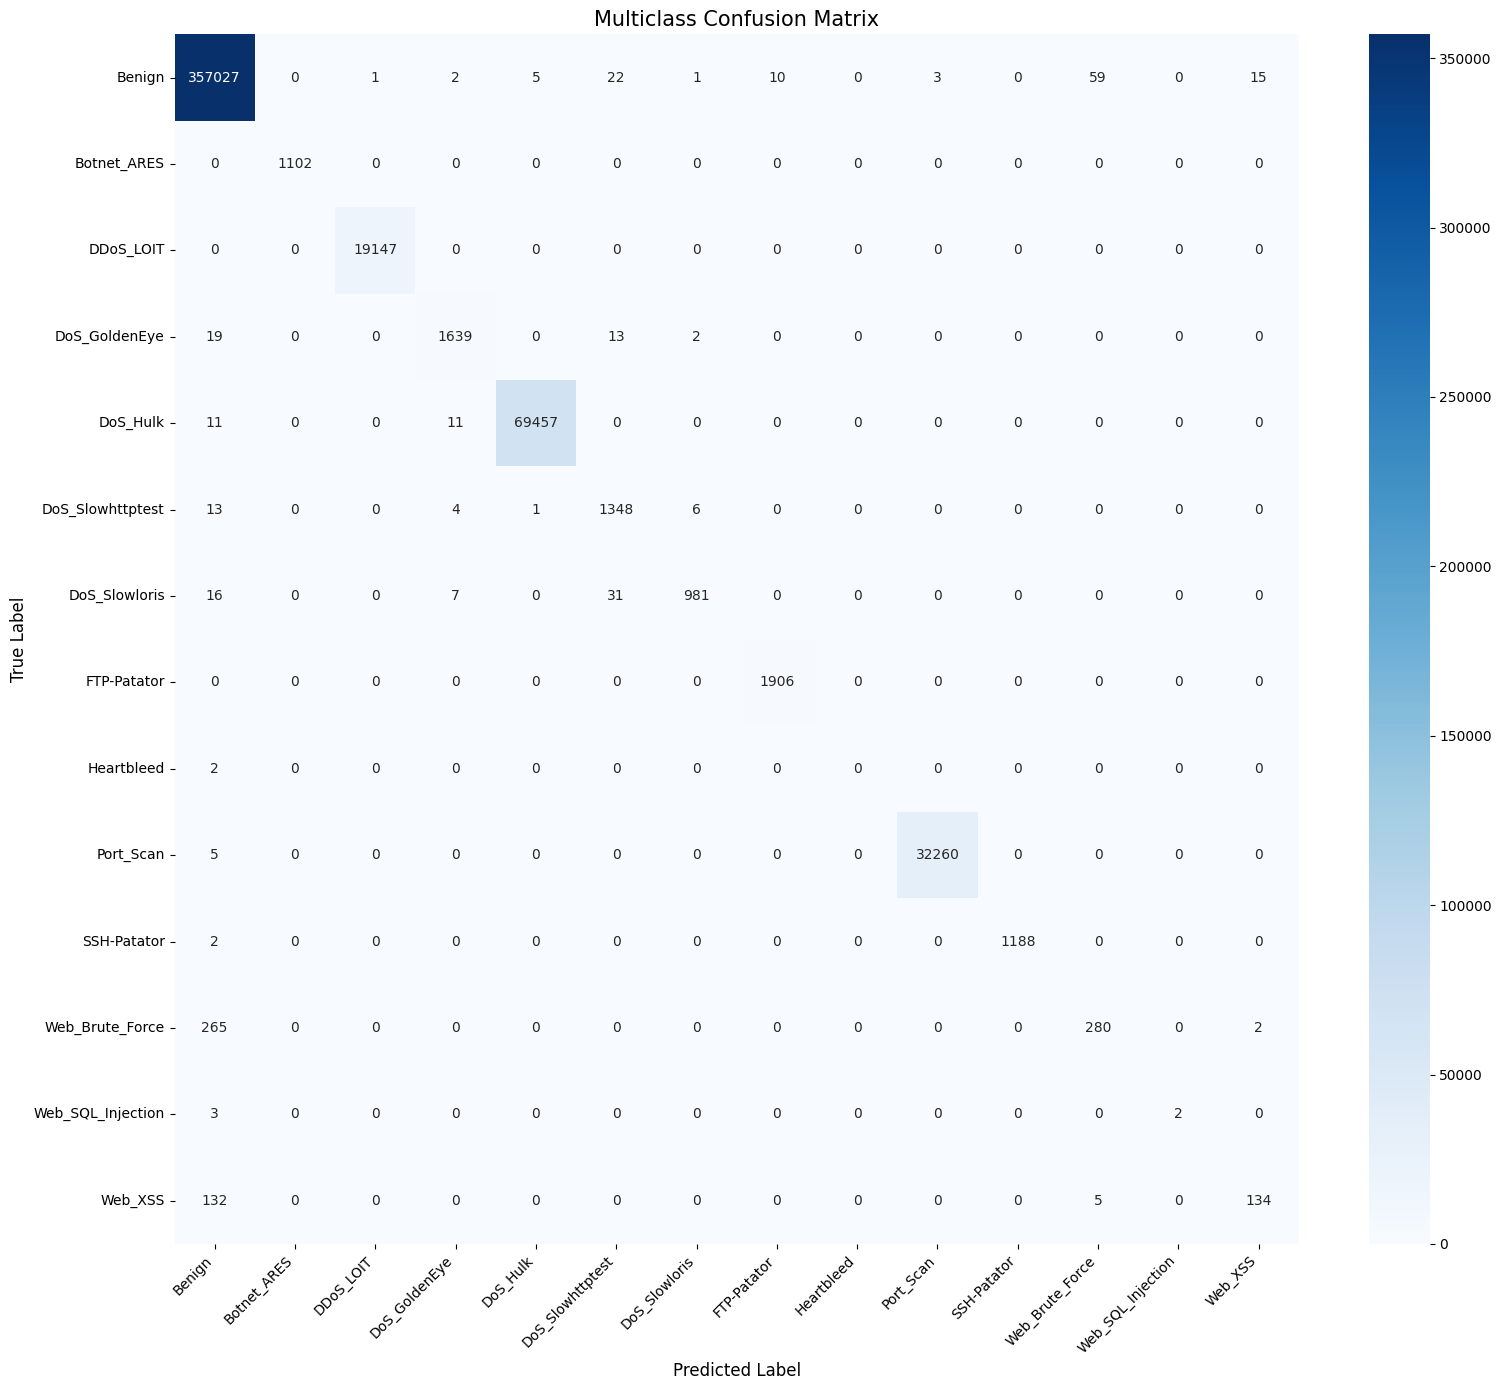


[INFO] Saving the model...
[INFO] Saving model package to ./models/v2/ids_model.joblib...
[SUCCESS] Model saved to: ./models/v2/ids_model.joblib
          Contains: model, label_encoder, scaler, selected_features, protocol_encoder


In [13]:
if __name__ == '__main__':
    
    if os.path.exists(DATASET_PATH):
        df = load_data(DATASET_PATH)
        
        # EDA
        check_for_nans_and_duplicates(df)
        cols_to_remove = ['flow_id', 'src_ip', 'src_port', 'dst_ip', 'timestamp']
        X_clean, y_clean = clean_data(df, cols_to_remove)

        
        X_encoded, protocol_encoder = encode_categorical_features(X_clean)
        y_multiclass, label_encoder = encode_multiclass_labels(y_clean)
        
        # EDA - Additional Visualizations
        # plot_class_breakdown_pie(y_multiclass, label_encoder.classes_)
        
        # Split (Stratified)
        X_train, X_test, y_train, y_test = split_dataset(X_encoded, y_multiclass)
        print(f"Training Set: {X_train.shape}")
        
        
        # 1. Remove Low Variance
        X_train_lv = remove_low_variance_features(X_train)
        X_test_lv = X_test[X_train_lv.columns]
        
        # 2. Remove Correlated
        X_train_corr = remove_correlated_features(X_train_lv)
        X_test_corr = X_test_lv[X_train_corr.columns]
        
        # 3. Feature Selection (Random Forest)
        X_train_selected, selected_feats = select_top_features_rf(X_train_corr, y_train, k=40)
        X_test_selected = X_test_corr[selected_feats]
        
        # 4. Scale Data
        X_train_scaled, X_test_scaled, scaler = scale_data(X_train_selected, X_test_selected)
        
        print(f"Train Shape: {X_train_scaled.shape}")
        
        print("\n--- Running Hyperparameter Optimization ---")
        rf_optimized = optimize_model(X_train_scaled, y_train)
        
        print("\n[INFO] Evaluating Optimized Model...")
        evaluate_model(rf_optimized, X_test_scaled, y_test, label_encoder)
        
        print("\n[INFO] Saving the model...")
        save_model(rf_optimized, label_encoder, scaler, selected_feats, protocol_encoder)
    else:
        print(f"[ERROR] Dataset not found at {DATASET_PATH}")